#FACE RECOGNITION<br/>
##Digital Signal and Image Management Project 2021-2022<br/>

Matteo Cesaro - 867350 - m.cesaro1@campus.unimib.it<br/>
Francesco Martinelli - 873685 - f.martinelli21@campus.unimib.it<br/>
Cristiano Ruttico - 809360 - c.ruttico@campus.unimib.it<br/>

## Setting funzioni e importazione librerie

Si connette il notebook al drive in cui è collocato il dataset contenente le immagini.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


Vengono importate le librerie per il processamento immagini, per la costruzione del modello e la valutazione.

In [2]:
#!pip3 install scikeras

In [3]:
# Base Library
import numpy as np

# Manage file
from time import time
from shutil import copyfile
import tarfile
import os
import cv2 as cv

# Visualizations
from tensorflow.keras.preprocessing import image
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow

#Manage Data
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Import base Model
from tensorflow import keras

# Model Specialization
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers, initializers
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.python.keras.layers.core import Dropout
from sklearn.decomposition import PCA
from tensorflow.keras.optimizers import Adam, SGD
from skimage.transform import resize
from sklearn.metrics import classification_report, confusion_matrix

#Classifier
from keras.models import Sequential
from keras.layers.core import Dense

face_detector = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_frontalface_default.xml')
ImageDataGenerator_obj = image.ImageDataGenerator(brightness_range=[0.4,0.8])


Si crea una funzione utile a creare un grafico per la valutazione del training del modello. 

In [4]:
#Loss and accuracy Graph
def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, network_history.history['loss'])
    plt.plot(x_plot, network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(x_plot, network_history.history['accuracy'])
    plt.plot(x_plot, network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

## Preprocessing Images

*Premessa: l'esplorazione del dataset non è stata eseguita poichè il dataset è stato creatodagli stessi autori manualmente e se ne conoscono esattamente le caratteristiche: 226 immagini di size variabile in formato JPG, in spazio RGB, che ritraggono gli autori del progetto.*

Si attribuiscono i nomi delle cartelle (classi) alla lista "it".

In [5]:
it = os.listdir("gdrive/MyDrive/DigitalSignal/Pics_beta/")
it.sort()
root_dir = "gdrive/MyDrive/DigitalSignal/Pics_beta/"

Le classi sono 3.

In [6]:
it

['cr_pic', 'fm_pic', 'mc_pic']

Le immagini su cui è già stato effettuato un primo crop vengono nuovamente riagliate utilizzando le coordinate del face detector.  Questo procedimento è stato aggiunto successivamente poichè il modello tendeva a basare una parte rilevante della predizione sulla capigliatura e veniva pertanto facilmente ingannato dall'utilizzo di accessori copricapo. Il face detector necessita delle immagini sotto forma di array di tipo intero e delle immagini in grayscale (per cui si utilizza il canale verde delle immagini RGB come proxy).

L'immagine poi viene ridimensionata e portata alla misura (299,299,3), dopodichè la si converte in valori "float32" e si portano i canali nel range [0,1] dal range [0,255] originale.

In [7]:
def preprocess_frame(img):
        xyzh = face_detector.detectMultiScale(img[:,:,1])
        if len(xyzh) >= 1:   
            xyzh = xyzh[0]
            img = img[xyzh[1]:xyzh[1] +xyzh[3], xyzh[0]+15:xyzh[0] + xyzh[2]-15]
            if img.shape[1]>0:
              img = resize(img, (299,299), mode="symmetric", preserve_range=True)
              
              return img

L'ultima parte del pre-processing consiste nella data augmentation, durante questa parte infatti viene randomicamente modificata la luminosità della foto poichè erano presenti delle tendenze di luminosità tra le varie classi.

In [8]:
#Defining a compact preprocessing function
categories = it

#Nel ds avremo array di tipo numpy relativi alle immagini
ds = []
#Nel ds_lab le etichette(label) relative alle immagini in ordine di indice
ds_lab = []

i = 0

for ctg in categories:
  path = root_dir + ctg
  items = os.listdir(path)
  for itm in items:  
        path_img = path+"/"+itm
        # data loading = setta tutte le immagini modificando la shape
        img = image.load_img(path_img)
        img = image.img_to_array(img, dtype="uint8")       
        frame = preprocess_frame(img)
        if (frame is not None) and (frame.shape == (299,299,3)):
            frame = np.expand_dims(frame, 0)
            iterator = ImageDataGenerator_obj.flow(frame, batch_size=1)
            chunk = iterator.next()
            frame = chunk[0].astype('float32')/255
            ds.append(frame)
            ds_lab.append(i)

  i += 1

In [9]:
#Conversione da lista in np.array dei risultati
ds = np.asarray(ds)
ds_lab = np.asarray(ds_lab)

ds, ds_lab = shuffle(ds, ds_lab)

Le immagini utilizzate per il training sono 203. Alcune immagini sono infatti state scartate poichè non erano state processate correttamente.

In [10]:
ds.shape

(203, 299, 299, 3)

Si mostra un esempio di immagine nel dataset.

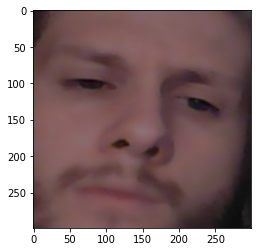

In [11]:
imshow(ds[5])

## Splitting in Training e Test Set

I dati vengono suddivisi in test set e training set. Si opera uno split randomico con proporzione 0.85 per il training set e 0.15 per il test set, questo split deriva dalla scarsità dei dati a disposizione.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(ds, ds_lab, test_size=0.15, random_state=2109)

## One-Hot Encoding

Le label vengono codificate con uno One-Hot Encoding. Le label sono così trasformate da vettore n-dimensionale a matrice n*k con k = 3 (numero di classi).

In [13]:
#Modifico le label convertendo il formato numerico in categorico
num_classes = len(it)



print('y_train_shape:', y_train.shape)
y_train = keras.utils.to_categorical(y_train, num_classes)
print('y_train_shape:', y_train.shape)

print('y_test_shape:', y_test.shape)
y_test = keras.utils.to_categorical(y_test, num_classes)
print('y_test_shape:', y_test.shape)

y_train_shape: (172,)
y_train_shape: (172, 3)
y_test_shape: (31,)
y_test_shape: (31, 3)


## Costruzione del Modello

Si utilizzano le reti neurali convoluzionali (CNN). Viene utilizzato in ordine: 

* Input layer
* Layer Convoluzionale con filtro (7,7) con attivazione ReLu
* MaxPooling layer
* Layer Convoluzionale con filtro (3,3) con attivazione ReLu
* Layer Convoluzionale con filtro (3,3) con attivazione ReLu
* MaxPooling layer
* Flattening layer
* Fully-Connected layer (Output) di dimensione 3 con attivazione Softmax

L'attivazine ReLu è stata scelta per gli hidden layer perchè rappresenta tendenzialmente una buona scelta per questo compito, mentre la softmax è la funzione di output indicata per la classificazione multiclasse. I pooling layer servivano per rendere meno pesante la computazione (dovendo implementare il modello durante lo streaming).

In [36]:
model = Sequential()
model.add(layers.Input(shape=(299,299,3)))
model.add(layers.Conv2D(64,kernel_size=(7,7), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(32,kernel_size=(3,3), activation='relu'))
model.add(layers.Conv2D(16,kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(3, activation= 'softmax'))


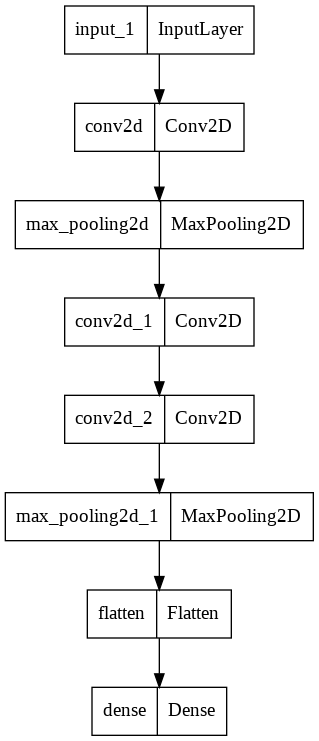

In [15]:
keras.utils.plot_model(model)

## Training

Si procede al training del modello. Come numero di epochs sono state scelte 15 iterazione. Data la dimensione piccola del dataset la batch size è stata impostata a 15. Il criterio del validation split ricalca quello dello split per training e test set. L'ottimizzatore utilizzato è Adam perchè offre generalmente ottimi risultati, il learning rate è stato settato a 0.00005 perchè permettaeva la convergenza rapida e con buoni risultati.

In [37]:
n_epochs = 7
batch_size = 16
validation_split = 0.05
l_rate = 0.0003

In [17]:
print(type(X_train), " ", X_train[0].shape)
print(type(y_train), " ", y_train.shape)

<class 'numpy.ndarray'>   (299, 299, 3)
<class 'numpy.ndarray'>   (172, 3)


In [38]:
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=l_rate), metrics= ["accuracy"])
network_history = model.fit(X_train, y_train, epochs=n_epochs, batch_size = batch_size, validation_split=validation_split)

score = model.evaluate(X_test, y_test, verbose=0)
print("Test Loss: ", score[0])
print("Test Acc.: ", score[1])

Epoch 1/7
11/11 [==============================] - 2s 153ms/step - loss: 0.9679 - accuracy: 0.4172 - val_loss: 0.6537 - val_accuracy: 1.0000
Epoch 2/7
11/11 [==============================] - 1s 129ms/step - loss: 0.6465 - accuracy: 0.7669 - val_loss: 0.2578 - val_accuracy: 1.0000
Epoch 3/7
11/11 [==============================] - 1s 130ms/step - loss: 0.4337 - accuracy: 0.8098 - val_loss: 0.2074 - val_accuracy: 1.0000
Epoch 4/7
11/11 [==============================] - 1s 130ms/step - loss: 0.4356 - accuracy: 0.8282 - val_loss: 0.0558 - val_accuracy: 1.0000
Epoch 5/7
11/11 [==============================] - 1s 131ms/step - loss: 0.3826 - accuracy: 0.8528 - val_loss: 0.1012 - val_accuracy: 1.0000
Epoch 6/7
11/11 [==============================] - 1s 127ms/step - loss: 0.2098 - accuracy: 0.9448 - val_loss: 0.9183 - val_accuracy: 0.5556
Epoch 7/7
11/11 [==============================] - 1s 128ms/step - loss: 0.4111 - accuracy: 0.8344 - val_loss: 0.0541 - val_accuracy: 1.0000
Test Loss:  0

Si tracciano i grafici sul training del modello con loss e accuracy per epoch. I grafici sono coerenti con quanto atteso dalla teoria ma la scarsa smoothness deriva dalla scarsità dei dati in particolare per la validation.

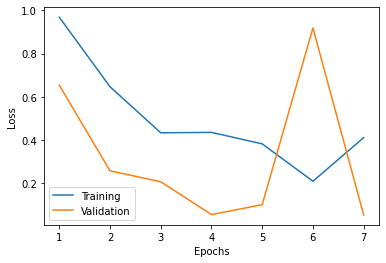

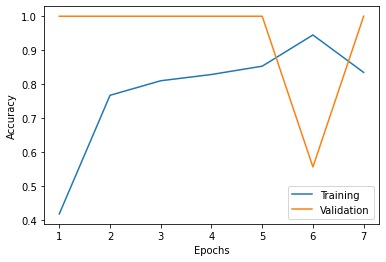

In [39]:
x_plot = list(range(1,n_epochs+1))
plot_history(network_history)


Viene mostrato a schermo il modello addestrato.

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 293, 293, 64)      9472      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 146, 146, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 144, 144, 32)      18464     
                                                                 
 conv2d_2 (Conv2D)           (None, 142, 142, 16)      4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 71, 71, 16)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 80656)             0

## Analisi dei Risultati

Si mostrano il classification report e la matrice di confusione.

In [21]:
yc_pred = model.predict(X_test)

In [22]:
y_pred = np.argmax(yc_pred, axis=1)

In [23]:
y_act = np.argmax(y_test, axis=1)

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00        11

    accuracy                           1.00        31
   macro avg       1.00      1.00      1.00        31
weighted avg       1.00      1.00      1.00        31

Confusion matrix:
[[12  0  0]
 [ 0  8  0]
 [ 0  0 11]]


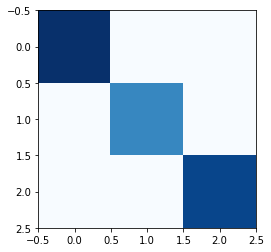

In [24]:
# Classification report
print('Classification report:')
print(classification_report(y_act, y_pred))

# Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_act, y_pred)
print(cm)
plt.imshow(cm, cmap=plt.cm.Blues)

Il modello ottiene ottimi risultati. Nelle precedenti computazioni tendeva a confondere spesso la classe "cr" con la classe "fm" con cappuccio o differenti tipi di illuminazione ma rispettivamente il secondo crop e lo scaling delle immagini sembrano aver risolto le due problematiche.

La parte successiva era stata utilizzata per approfondire nel training set gli errori commessi.

In [25]:
xc_pred = model.predict(X_train)

In [26]:
x_pred = np.argmax(xc_pred, axis=1)

In [27]:
x_act = np.argmax(y_train, axis=1)

Classification report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95        70
           1       1.00      0.86      0.92        57
           2       1.00      1.00      1.00        45

    accuracy                           0.95       172
   macro avg       0.97      0.95      0.96       172
weighted avg       0.96      0.95      0.95       172

Confusion matrix:
[[70  0  0]
 [ 8 49  0]
 [ 0  0 45]]


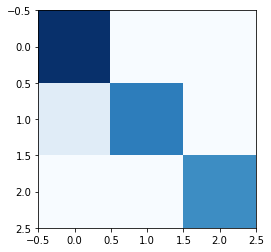

In [28]:
# Classification report
print('Classification report:')
print(classification_report(x_act, x_pred))

# Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(x_act, x_pred)
print(cm)
plt.imshow(cm, cmap=plt.cm.Blues)

Si cercano gli indici degli errori per mostrare le immagini misclassificate.

In [29]:
idx=[]
for i in range(0, len(x_act)):
  if x_act[i] != x_pred[i]:
    idx.append(i)

print(idx)

[3, 34, 41, 53, 66, 93, 119, 146]


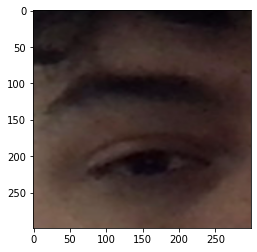

In [30]:
imshow(X_train[24])

 Con il nuovo modello gli errori sono una foto priva di un volto,probabilmente dovuta ad un errore del face detector e alcune foto della classe "fm" classificata come "cr". Il fatto che non sia presente un pattern fisso nei dati (se non un accenno di somiglianza tra le due classi) puó essere valutata come una riuscita nel tentativo di generalizzazione del modello. Si evidenzia tuttavia che il cappuccio continua a rappresentare una variazione ostica per il modello.

## Esportazione del modello per la Demo

In [31]:
model_json = model.to_json()
with open("model_finale.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_finale.h5")
print("Saved model to disk")

Saved model to disk
